In [ ]:
import numpy as np
import torch
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder,RobustScaler
import torch.optim.lr_scheduler as lr_scheduler

## Dataset Loading

In [ ]:
# Load the dataset
df = pd.read_csv("Housing-1 - Housing-1.csv")

In [ ]:
df.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


In [ ]:
df.nunique()

price               219
area                284
bedrooms              6
bathrooms             4
stories               4
mainroad              2
guestroom             2
basement              2
hotwaterheating       2
airconditioning       2
parking               4
prefarea              2
furnishingstatus      3
dtype: int64

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545 entries, 0 to 544
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   price             545 non-null    int64 
 1   area              545 non-null    int64 
 2   bedrooms          545 non-null    int64 
 3   bathrooms         545 non-null    int64 
 4   stories           545 non-null    int64 
 5   mainroad          545 non-null    object
 6   guestroom         545 non-null    object
 7   basement          545 non-null    object
 8   hotwaterheating   545 non-null    object
 9   airconditioning   545 non-null    object
 10  parking           545 non-null    int64 
 11  prefarea          545 non-null    object
 12  furnishingstatus  545 non-null    object
dtypes: int64(6), object(7)
memory usage: 55.5+ KB


In [ ]:
df.describe()

,price,area,bedrooms,bathrooms,stories,parking
count,5.450000e+02,545.000000,545.000000,545.000000,545.000000,545.000000
mean,4.766729e+06,5150.541284,2.965138,1.286239,1.805505,0.693578
std,1.870440e+06,2170.141023,0.738064,0.502470,0.867492,0.861586
min,1.750000e+06,1650.000000,1.000000,1.000000,1.000000,0.000000
25%,3.430000e+06,3600.000000,2.000000,1.000000,1.000000,0.000000
50%,4.340000e+06,4600.000000,3.000000,1.000000,2.000000,0.000000
75%,5.740000e+06,6360.000000,3.000000,2.000000,2.000000,1.000000
max,1.330000e+07,16200.000000,6.000000,4.000000,4.000000,3.000000


In [ ]:
df.isna().sum()

price               0
area                0
bedrooms            0
bathrooms           0
stories             0
mainroad            0
guestroom           0
basement            0
hotwaterheating     0
airconditioning     0
parking             0
prefarea            0
furnishingstatus    0
dtype: int64

In [ ]:
df.duplicated().sum()

0

In [ ]:
# Step 2: Encoding Categorical Variables
# Use OneHotEncoder for categorical features
categorical_cols = ['mainroad', 'guestroom', 'basement', 'hotwaterheating',
                    'airconditioning', 'prefarea']

# Corrected OneHotEncoder usage
encoder = OneHotEncoder(sparse_output=False, drop='first')  # drop='first' to avoid dummy variable trap
encoded_categorical = encoder.fit_transform(df[categorical_cols])
encoded_df = pd.DataFrame(encoded_categorical, columns=encoder.get_feature_names_out(categorical_cols))


# Step 3: Combine encoded categorical columns with the original DataFrame
df = pd.concat([df.reset_index(drop=True), encoded_df.reset_index(drop=True)], axis=1)

# Step 4: Drop the original categorical columns from the DataFrame
df.drop(categorical_cols, axis=1, inplace=True)

LabelEncoder = LabelEncoder()
df['furnishingstatus'] = LabelEncoder.fit_transform(df['furnishingstatus'])
df.drop('furnishingstatus', axis=1, inplace=True)
# Step 5: Feature Scaling
scaler = StandardScaler()
numerical_cols = ['area', 'bedrooms', 'bathrooms', 'stories', 'parking']
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

In [ ]:
df

,price,area,bedrooms,bathrooms,stories,parking,mainroad_yes,guestroom_yes,basement_yes,hotwaterheating_yes,airconditioning_yes,prefarea_yes
0,13300000,1.046726,1.403419,1.421812,1.378217,1.517692,1.0,0.0,0.0,0.0,1.0,1.0
1,12250000,1.757010,1.403419,5.405809,2.532024,2.679409,1.0,0.0,0.0,0.0,1.0,0.0
2,12250000,2.218232,0.047278,1.421812,0.224410,1.517692,1.0,0.0,1.0,0.0,0.0,1.0
3,12215000,1.083624,1.403419,1.421812,0.224410,2.679409,1.0,0.0,1.0,0.0,1.0,1.0
4,11410000,1.046726,1.403419,-0.570187,0.224410,1.517692,1.0,1.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
540,1820000,-0.991879,-1.308863,-0.570187,-0.929397,1.517692,1.0,0.0,1.0,0.0,0.0,0.0
541,1767150,-1.268613,0.047278,-0.570187,-0.929397,-0.805741,0.0,0.0,0.0,0.0,0.0,0.0
542,1750000,-0.705921,-1.308863,-0.570187,-0.929397,-0.805741,1.0,0.0,0.0,0.0,0.0,0.0
543,1750000,-1.033389,0.047278,-0.570187,-0.929397,-0.805741,0.0,0.0,0.0,0.0,0.0,0.0


## Data Cleaning Process for Outlier Detection

**Outlier Detection Using IQR**:
   - We calculate the first (Q1) and third (Q3) quartiles of the target variable `y`.
   - The Interquartile Range (IQR) is computed as the difference between Q3 and Q1. This IQR helps identify the spread of the middle 50% of the data.
   - Using the IQR, we set lower and upper bounds for outlier detection: any data point falling below the lower bound (`Q1 - 1.5 * IQR`) or above the upper bound (`Q3 + 1.5 * IQR`) is considered an outlier.






In [ ]:
# Calculate the first quartile (Q1) of the target variable 'price'
Q1 = np.percentile(np.array(df['price']).reshape(-1,1), 25)

# Calculate the third quartile (Q3) of the target variable 'price'
Q3 = np.percentile(np.array(df['price']).reshape(-1,1), 75)

# Calculate the Interquartile Range (IQR)
IQR = Q3 - Q1

# Determine the lower and upper bounds for detecting outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df = df[(df['price'] >= lower_bound) & (df['price'] <= upper_bound)]

# Update X and y with the cleaned data
X = df.drop('price', axis=1) # Reassign X with the cleaned 'area' data
y = np.array(df['price'])  # Reassign y with the cleaned 'price' data

X

,area,bedrooms,bathrooms,stories,parking,mainroad_yes,guestroom_yes,basement_yes,hotwaterheating_yes,airconditioning_yes,prefarea_yes
15,0.391790,1.403419,-0.570187,0.224410,1.517692,1.0,0.0,1.0,0.0,0.0,0.0
16,0.668524,1.403419,1.421812,0.224410,0.355976,1.0,1.0,1.0,0.0,1.0,1.0
17,1.544847,0.047278,1.421812,2.532024,1.517692,1.0,0.0,0.0,0.0,1.0,0.0
18,-0.253922,0.047278,1.421812,0.224410,1.517692,1.0,1.0,0.0,0.0,1.0,0.0
19,0.585503,0.047278,1.421812,0.224410,0.355976,1.0,0.0,0.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
540,-0.991879,-1.308863,-0.570187,-0.929397,1.517692,1.0,0.0,1.0,0.0,0.0,0.0
541,-1.268613,0.047278,-0.570187,-0.929397,-0.805741,0.0,0.0,0.0,0.0,0.0,0.0
542,-0.705921,-1.308863,-0.570187,-0.929397,-0.805741,1.0,0.0,0.0,0.0,0.0,0.0
543,-1.033389,0.047278,-0.570187,-0.929397,-0.805741,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
X.dtypes

area                   float64
bedrooms               float64
bathrooms              float64
stories                float64
parking                float64
mainroad_yes           float64
guestroom_yes          float64
basement_yes           float64
hotwaterheating_yes    float64
airconditioning_yes    float64
prefarea_yes           float64
dtype: object

In [ ]:
# Train-test split: 60% train , 40% val + test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
# Train-test split: 20% val, 20% test
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)
X_val=scaler.transform(X_val)
y_train = y_train.reshape(-1, 1)
y_val = y_val.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)
y_train = scaler.fit_transform(y_train)
y_val = scaler.transform(y_val)
y_test = scaler.transform(y_test)

In [ ]:
# Convert data to PyTorch tensors
X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()
X_val = torch.from_numpy(X_val).float()
y_val = torch.from_numpy(y_val).float()
X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()

# Implementing a neural network for regression

In [ ]:
import torch.nn as nn

class HousingModel(nn.Module):
    def __init__(self, input_size):
        super(HousingModel, self).__init__()
        # Input Layer
        self.linear1 = nn.Linear(input_size, 128)
        self.bn1 = nn.BatchNorm1d(128)  # Batch Normalization
        self.dropout1 = nn.Dropout(1/3)
        self.elu1 = nn.ELU()

        # Hidden Layer 1
        self.linear2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)  # Batch Normalization
        self.dropout2 = nn.Dropout(1/3)
        self.elu2 = nn.ELU()

        # Hidden Layer 2
        self.linear3 = nn.Linear(64, 32)
        self.bn3 = nn.BatchNorm1d(32)  # Batch Normalization
        self.dropout3 = nn.Dropout(1/3)
        self.elu3 = nn.ELU()

        # Hidden Layer 3
        self.linear4 = nn.Linear(32, 16)
        self.bn4 = nn.BatchNorm1d(16)  # Batch Normalization
        self.dropout4 = nn.Dropout(1/3)
        self.elu4 = nn.ELU()

        # Output Layer
        self.output = nn.Linear(16, 1)

    def forward(self, x):
        x = self.linear1(x)
        x = self.bn1(x)  # Batch Normalization
        x = self.dropout1(x)
        x = self.elu1(x)

        x = self.linear2(x)
        x = self.bn2(x)  # Batch Normalization
        x = self.dropout2(x)
        x = self.elu2(x)

        x = self.linear3(x)
        x = self.bn3(x)  # Batch Normalization
        x = self.dropout3(x)
        x = self.elu3(x)

        x = self.linear4(x)
        x = self.bn4(x)  # Batch Normalization
        x = self.dropout4(x)
        x = self.elu4(x)

        return self.output(x)


# Training and Validation


In [ ]:
epochs = 500
model = HousingModel(input_size=11)
criterion = nn.MSELoss()  # Use MSE for regression
optimizer = optim.Adam(model.parameters(), lr=0.0001)  # Smaller learning rate and weight decay
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.1, verbose=True)  # Adjust learning rate schedule
batch_size = 32
num_samples = X_train.shape[0]
num_batches = num_samples // batch_size

best_val_loss = float('inf')

for epoch in range(epochs):
    # Shuffle data
    perm = torch.randperm(X_train.size(0))
    X_train = X_train[perm]
    y_train = y_train[perm]

    # --- Training Phase ---
    model.train()

    for batch_idx in range(num_batches):
        start_idx = batch_idx * batch_size
        end_idx = min((batch_idx + 1) * batch_size, num_samples)
        data = X_train[start_idx:end_idx]
        target = y_train[start_idx:end_idx]

        # Forward pass
        y_pred = model(data)

        # Compute the loss
        loss = criterion(y_pred, target)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # --- Validation Phase ---
    model.eval()
    with torch.no_grad():
        y_val_pred = model(X_val)
        val_loss = criterion(y_val_pred, y_val)

    # Update learning rate based on validation loss
    scheduler.step(val_loss)

    # Print the results every 50 epochs
    if (epoch + 1) % 50 == 0:
        print(f'Epoch [{epoch + 1}/{epochs}], Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}')


C:\Users\Dell\AppData\Roaming\Python\Python311\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [50/500], Train Loss: 0.7688, Val Loss: 0.6087
Epoch [100/500], Train Loss: 0.9164, Val Loss: 0.6121
Epoch [150/500], Train Loss: 0.7260, Val Loss: 0.6107
Epoch [200/500], Train Loss: 0.5280, Val Loss: 0.6134
Epoch [250/500], Train Loss: 0.4746, Val Loss: 0.6115
Epoch [300/500], Train Loss: 0.7195, Val Loss: 0.6111
Epoch [350/500], Train Loss: 0.4781, Val Loss: 0.6139
Epoch [400/500], Train Loss: 0.5796, Val Loss: 0.6166
Epoch [450/500], Train Loss: 0.7404, Val Loss: 0.6187
Epoch [500/500], Train Loss: 0.4710, Val Loss: 0.6159


## Model Evaluation with No Gradient Calculation

The following code evaluates the performance of a trained model on the test dataset by computing common regression metrics like Mean Squared Error (MSE), Mean Absolute Error (MAE), and the R-squared (R²) score.


In [ ]:
# Evaluation with no gradient calculation
with torch.no_grad():
    y_pred_test = model(X_test)
    # Compute the metrics
    mse = mean_squared_error(y_test, y_pred_test)
    mae = mean_absolute_error(y_test, y_pred_test)
    r2 = r2_score(y_test, y_pred_test)

    # Print the results
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"R-squared (R2): {r2:.4f}")


Mean Squared Error (MSE): 0.3974
Mean Absolute Error (MAE): 0.4870
R-squared (R2): 0.7350


# Model Testing Function

In [ ]:
# Evaluate the model on the test set
with torch.no_grad():
    y_pred_test = model(X_test)
    test_loss = criterion(y_pred_test, y_test)
    print(f'Test Loss: {test_loss.item():.4f}')

Test Loss: 0.3974


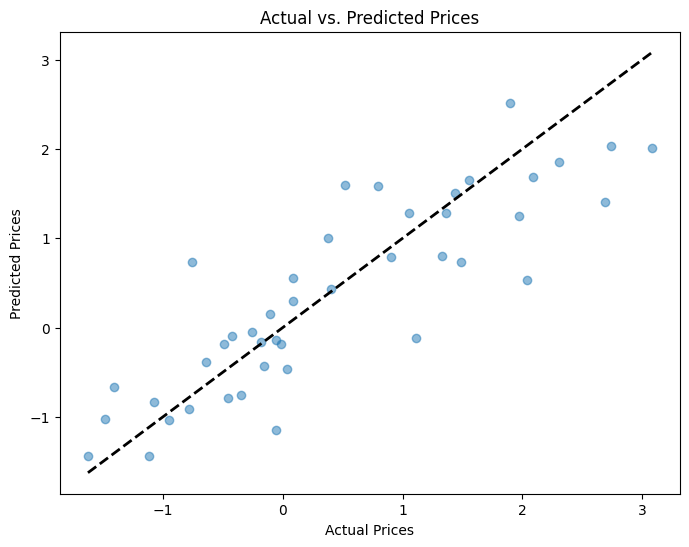

In [ ]:
import matplotlib.pyplot as plt

# Assuming you have y_test (actual prices) and y_pred_test (predicted prices)

plt.figure(figsize=(8, 6))  # Adjust figure size if needed
plt.scatter(y_test, y_pred_test, alpha=0.5)  # Scatter plot
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Actual vs. Predicted Prices")

# Add a diagonal line for reference (perfect predictions)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)

plt.show()